In [1]:
import torch
from torch_geometric.datasets import Planetoid
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch_geometric.utils import to_networkx
from sklearn.metrics import roc_auc_score
from surprise import accuracy, Reader, SVD, KNNBasic, Dataset
from surprise.model_selection import train_test_split
import random
random.seed(42)

In [2]:
# Import citeseer dataset from planetoid
dataset = Planetoid(root='/tmp/Citeseer', name='Citeseer')

In [3]:
# Get the first graph object
graph_data = dataset[0]
graph_data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [4]:
#Number of different classes
print(f'Number of classes: {dataset.num_classes}')

Number of classes: 6


# Data epxloratory analysis

In [8]:
graph  = to_networkx(graph_data, to_undirected=False, node_attrs=['x', 'y'])

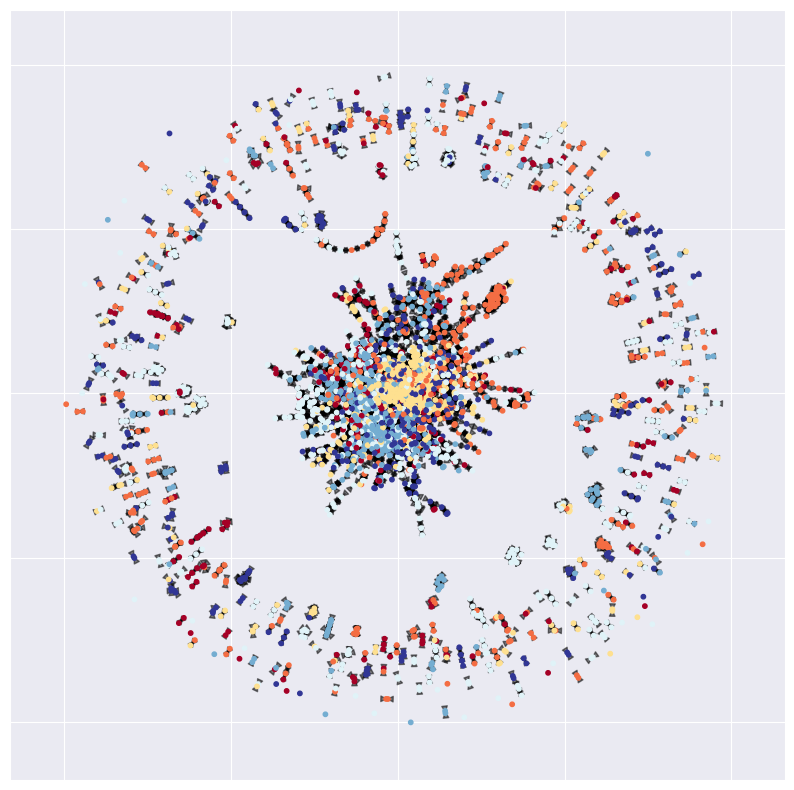

In [9]:
# Plot the graph with color depending on the label
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos=pos, node_size=10, cmap=plt.cm.RdYlBu, node_color=[graph.nodes[i]['y'] for i in graph.nodes()])

nx.draw_networkx_edges(graph, pos=pos, alpha=0.5)
plt.show()


In [26]:
print(f'Number of nodes: {graph.number_of_nodes()}')
print(f'Number of edges: {graph.number_of_edges()}')

Number of nodes: 3327
Number of edges: 9104


# Define preprocessing and training functions

In [37]:
def train_and_evaluate_SVD(trainset, testset, threshold=0.9):
    # Build the SVD model with similarity regularization
    model = SVD()
    model.fit(trainset)

    # Get the true labels (actual ratings) for the test set
    true_labels = [1 for _, _, rating in testset]

    num_negatives = len(testset)  # Same number as the positive samples
    negative_samples = []
    for _ in range(num_negatives):
        user = random.choice(list(graph.nodes))
        item = random.choice(list(graph.nodes))
        while graph.has_edge(user, item):
            user = random.choice(list(graph.nodes))
            item = random.choice(list(graph.nodes))
        negative_samples.append((user, item, 0))  # Negative label (0)

    # Combine positive and negative samples
    balanced_testset = testset + negative_samples

    # Get the predicted ratings for the test set
    predictions = model.test(balanced_testset)
    predicted_labels = [1 if pred.est > threshold else 0 for pred in predictions]
    # Compute the AUC for each class separately
    auc = roc_auc_score(true_labels + [0] * num_negatives, predicted_labels, multi_class='ovr')
    return auc

In [38]:
#Build ratings dataframe using the adjacency matrix
def build_ratings_dataframe(graph):
    data = [(node1, node2, 1) for node1, node2 in graph.edges()]

    reader = Reader(rating_scale=(0, 1))
    surprise_data = Dataset.load_from_df(pd.DataFrame(data, columns=['user', 'item', 'rating']), reader)
    trainset, testset = train_test_split(surprise_data, test_size=.20)
    return trainset, testset

In [39]:
#Compute adamic adar similarity
def compute_adamic_adar_similarity(graph):
    # Compute the Adamic-Adar similarity matrix
    similarities = nx.adamic_adar_index(graph, list(graph.edges()))
    return [(node1, node2, sim) for node1, node2, sim in similarities]

In [40]:
#Compute jaccard similarity
def compute_jaccard_similarity(graph):
    # Compute the Jaccard similarity matrix
    similarities = nx.jaccard_coefficient(graph, list(graph.edges()))
    return [(node1, node2, sim) for node1, node2, sim in similarities]

In [41]:
#Compute preferential attachment similarity
def compute_preferential_attachment_similarity(graph):
    # Compute the preferential attachment similarity matrix
    similarities = nx.preferential_attachment(graph, list(graph.edges()))
    return [(node1, node2, sim) for node1, node2, sim in similarities]

In [42]:
#Compute resource allocation similarity
def compute_resource_allocation_similarity(graph):
    # Compute the resource allocation similarity matrix
    similarities = nx.resource_allocation_index(graph, list(graph.edges()))
    return [(node1, node2, sim) for node1, node2, sim in similarities]

In [43]:
def build_similarity(graph, similarity_measure='adamic'):
    graph = graph.to_undirected()
    if similarity_measure == 'adamic':
        return compute_adamic_adar_similarity(graph)
    elif similarity_measure == 'jaccard':
        return compute_jaccard_similarity(graph)
    elif similarity_measure == 'resource':
        return compute_resource_allocation_similarity(graph)
    else:
        raise ValueError('Invalid similarity measure')


In [44]:
from surprise import KNNBasic
def train_and_evaluate_KNN(trainset, testset, threshold=0.9):
    # Build the SVD model with similarity regularization
    model = KNNBasic(k=20,)

    model.fit(trainset)

    # Get the true labels (actual ratings) for the test set
    true_labels = [1 for _, _, rating in testset]

    num_negatives = len(testset)  # Same number as the positive samples
    negative_samples = []
    for _ in range(num_negatives):
        user = random.choice(list(graph.nodes))
        item = random.choice(list(graph.nodes))
        while graph.has_edge(user, item):
            user = random.choice(list(graph.nodes))
            item = random.choice(list(graph.nodes))
        negative_samples.append((user, item, 0))  # Negative label (0)

    # Combine positive and negative samples
    balanced_testset = testset + negative_samples

    # Get the predicted ratings for the test set
    predictions = model.test(balanced_testset)
    predicted_labels = [1 if pred.est > threshold else 0 for pred in predictions]


    # Compute the AUC for each class separately
    auc = roc_auc_score(true_labels + [0] * num_negatives, predicted_labels, multi_class='ovr')
    return auc


In [45]:
def test_similarity_measure(graph):
    for similarity_measure in ['adamic', 'jaccard', 'resource']:
        similarities = build_similarity(graph, similarity_measure=similarity_measure)
        reader = Reader(rating_scale=(0, 1))
        surprise_data = Dataset.load_from_df(pd.DataFrame(list(similarities), columns=['user', 'item', 'rating']), reader)
        trainset, testset = train_test_split(surprise_data, test_size=0.2)
        mean_similarities = np.mean([sim for _, _, sim in similarities])
        knn_auc = train_and_evaluate_KNN(trainset, testset, threshold=mean_similarities)
        svd_auc = train_and_evaluate_SVD(trainset, testset, threshold=mean_similarities)
        print(f'Similarity measure: {similarity_measure}, KNN_AUC: {knn_auc}, SVD_AUC: {svd_auc}')

# Testing models

In [46]:
test_similarity_measure(graph)

Computing the msd similarity matrix...
Done computing similarity matrix.
Similarity measure: adamic, KNN_AUC: 0.46103183315038415, SVD_AUC: 0.5735455543358946
Computing the msd similarity matrix...
Done computing similarity matrix.
Similarity measure: jaccard, KNN_AUC: 0.5828759604829857, SVD_AUC: 0.5373216245883644
Computing the msd similarity matrix...
Done computing similarity matrix.
Similarity measure: resource, KNN_AUC: 0.5850713501646543, SVD_AUC: 0.5735455543358947


In [47]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
import os
from gensim import models
def transform_data(graph, force_retrain=False):
    dataframe_filename = 'all_features.csv'
    if os.path.exists(dataframe_filename) and not force_retrain:
        return pd.read_csv(dataframe_filename)
    data = [(node1, node2, 1) for node1, node2 in graph.edges()]
    #add negative samples
    num_negatives = len(data)  # Same number as the positive samples
    negative_samples = []
    for _ in range(num_negatives):
        user = random.choice(list(graph.nodes))
        item = random.choice(list(graph.nodes))
        while graph.has_edge(user, item):
            user = random.choice(list(graph.nodes))
            item = random.choice(list(graph.nodes))
        negative_samples.append((user, item, 0))  # Negative label (0)
    data = data + negative_samples

    #shuffle data
    random.shuffle(data)

    #Build a dataframe src, dst, link
    df = pd.DataFrame(data, columns=['src', 'dst', 'link'])


    pagerank = nx.pagerank(graph, alpha=0.9, max_iter=50)
    degree = dict(graph.degree())
    degCent = nx.degree_centrality(graph)
    betCent = nx.betweenness_centrality(graph, normalized=True, endpoints=True)
    cloCent = nx.closeness_centrality(graph)
    eigCent = nx.eigenvector_centrality(graph)
    hubs_dict, authorities_dict = nx.hits(graph)
    node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=8)
    # Embed nodes
    node2vec_filepath = 'node2vec.model'
    if os.path.exists(node2vec_filepath) and not force_retrain:
        print('Loading node2vec model')
        model = models.Word2Vec.load(node2vec_filepath)
    else:
        print('Training node2vec model')
        model = node2vec.fit(window=10, min_count=1, batch_words=4)
        # Save embeddings for later use
        model.save('node2vec.model')
    # Embed edges using Hadamard method
    edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
    final_data = []
    for index, row in df.iterrows():
        src = row['src']
        dst = row['dst']
        data_list = []
        data_list.append(pagerank[src])
        data_list.append(pagerank[dst])
        data_list.append(degree[src])
        data_list.append(degree[dst])
        data_list.append(degCent[src])
        data_list.append(degCent[dst])
        data_list.append(betCent[src])
        data_list.append(betCent[dst])
        data_list.append(cloCent[src])
        data_list.append(cloCent[dst])
        data_list.append(eigCent[src])
        data_list.append(eigCent[dst])
        data_list.append(hubs_dict[src])
        data_list.append(hubs_dict[dst])
        data_list.append(authorities_dict[src])
        data_list.append(authorities_dict[dst])
        data_list.append(edges_embs[(str(src), str(dst))])
        final_data.append(data_list)

    col_list = ['src_pagerank', 'dst_pagerank', 'src_degree', 'dst_degree', 'src_degCent', 'dst_degCent', 'src_betCent', 'dst_betCent', 'src_cloCent', 'dst_cloCent', 'src_eigCent', 'dst_eigCent', 'src_hubs', 'dst_hubs', 'src_authorities', 'dst_authorities', 'edge_emb']
    new_df = pd.DataFrame(final_data, columns=col_list)
    new_df['link'] = df['link']
    # Split edge_emb column into 64 columns and name them as edge_emb_0, edge_emb_1, ..., edge_emb_63
    new_df = pd.concat([new_df.drop(['edge_emb'], axis=1), new_df['edge_emb'].apply(pd.Series).rename(columns=lambda x: 'edge_emb_' + str(x))], axis=1)

    # Save dataframe
    new_df.to_csv(dataframe_filename, index=False)
    return new_df


In [70]:
new_df = transform_data(graph)

In [71]:
new_df.columns

Index(['src_pagerank', 'dst_pagerank', 'src_degree', 'dst_degree',
       'src_degCent', 'dst_degCent', 'src_betCent', 'dst_betCent',
       'src_cloCent', 'dst_cloCent', 'src_eigCent', 'dst_eigCent', 'src_hubs',
       'dst_hubs', 'src_authorities', 'dst_authorities', 'link', 'edge_emb_0',
       'edge_emb_1', 'edge_emb_2', 'edge_emb_3', 'edge_emb_4', 'edge_emb_5',
       'edge_emb_6', 'edge_emb_7', 'edge_emb_8', 'edge_emb_9', 'edge_emb_10',
       'edge_emb_11', 'edge_emb_12', 'edge_emb_13', 'edge_emb_14',
       'edge_emb_15', 'edge_emb_16', 'edge_emb_17', 'edge_emb_18',
       'edge_emb_19', 'edge_emb_20', 'edge_emb_21', 'edge_emb_22',
       'edge_emb_23', 'edge_emb_24', 'edge_emb_25', 'edge_emb_26',
       'edge_emb_27', 'edge_emb_28', 'edge_emb_29', 'edge_emb_30',
       'edge_emb_31', 'edge_emb_32', 'edge_emb_33', 'edge_emb_34',
       'edge_emb_35', 'edge_emb_36', 'edge_emb_37', 'edge_emb_38',
       'edge_emb_39', 'edge_emb_40', 'edge_emb_41', 'edge_emb_42',
       'edge_emb_

In [72]:
new_df.head(5)

,src_pagerank,dst_pagerank,src_degree,dst_degree,src_degCent,dst_degCent,src_betCent,dst_betCent,src_cloCent,dst_cloCent,...,edge_emb_54,edge_emb_55,edge_emb_56,edge_emb_57,edge_emb_58,edge_emb_59,edge_emb_60,edge_emb_61,edge_emb_62,edge_emb_63
0,0.000612,0.000499,16,14,0.004811,0.004209,0.003535,6.375899e-04,0.080115,0.079708,...,0.109737,0.341694,0.127114,0.019481,0.650054,-0.008303,1.067486,0.168207,0.674174,0.194565
1,0.000924,0.000398,22,6,0.006615,0.001804,0.002742,7.657966e-04,0.078921,0.054292,...,0.947663,0.005225,0.420843,0.394920,0.019303,0.074599,0.314009,0.014686,0.716303,0.041943
2,0.000256,0.000663,8,20,0.002405,0.006013,0.000462,1.868864e-03,0.087510,0.089305,...,-0.003422,-0.008248,0.006624,0.184925,0.252156,0.721654,0.589947,-0.002803,0.370980,0.454201
3,0.000323,0.000305,8,2,0.002405,0.000601,0.002133,1.807403e-07,0.067068,0.000301,...,0.134858,-0.043329,-0.107114,0.117522,-0.210618,0.052613,-0.118849,0.027892,3.874283,0.085652
4,0.000295,0.000291,4,4,0.001203,0.001203,0.000002,1.355552e-06,0.000982,0.000775,...,0.037548,1.429127,0.019794,0.047499,0.323611,0.175476,0.021078,0.009885,1.290938,0.491509


In [82]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

In [83]:
def train_and_evaluate(df, test_size):
    X = df.drop(['link'], axis=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = df['link']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    #Gradient Boosting Classifier
    gb_clf = GradientBoostingClassifier(random_state=42)
    gb_clf.fit(X_train, y_train)
    y_pred = gb_clf.predict(X_test)
    #Print AUC score
    gradient_boost_auc = roc_auc_score(y_test, y_pred)
    print("Gradient boost AUC score: ", gradient_boost_auc)

    #XGBoost Classifier
    xgb_clf = xgb.XGBClassifier(random_state=42)
    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    #Print AUC score
    xgboost_auc = roc_auc_score(y_test, y_pred)
    print("XGbootAUC score: ", xgboost_auc)

    #Random Forest Classifier
    rf_clf = RandomForestClassifier(random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    #Print AUC score
    randomforest_auc = roc_auc_score(y_test, y_pred)
    print("Random Forest AUC score: ", randomforest_auc)

    #Logistic Regression
    lr_clf = LogisticRegression(random_state=42)
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(X_test)
    #Print AUC score
    logisticregression_auc = roc_auc_score(y_test, y_pred)
    return gradient_boost_auc, xgboost_auc, randomforest_auc, logisticregression_auc

In [88]:
res_df = pd.DataFrame(columns=['gradient_boost_auc', 'xgboost_auc', 'randomforest_auc', 'logisticregression_auc'])
page_rank_embedding_col = ['src_pagerank', 'dst_pagerank'] + ['edge_emb_' + str(i) for i in range(64)]
degree_embedding_col = ['src_degree', 'dst_degree'] + ['edge_emb_' + str(i) for i in range(64)]
degCent_embedding_col = ['src_degCent', 'dst_degCent'] + ['edge_emb_' + str(i) for i in range(64)]
betCent_embedding_col = ['src_betCent', 'dst_betCent'] + ['edge_emb_' + str(i) for i in range(64)]
cloCent_embedding_col = ['src_cloCent', 'dst_cloCent'] + ['edge_emb_' + str(i) for i in range(64)]
eigCent_embedding_col = ['src_eigCent', 'dst_eigCent'] + ['edge_emb_' + str(i) for i in range(64)]
hubs_embedding_col = ['src_hubs', 'dst_hubs'] + ['edge_emb_' + str(i) for i in range(64)]
authorities_embedding_col = ['src_authorities', 'dst_authorities'] + ['edge_emb_' + str(i) for i in range(64)]
embedding_col = ['edge_emb_' + str(i) for i in range(64)]
without_embedding_col = ['src_pagerank', 'dst_pagerank', 'src_degree', 'dst_degree', 'src_degCent', 'dst_degCent', 'src_betCent', 'dst_betCent', 'src_cloCent', 'dst_cloCent', 'src_eigCent', 'dst_eigCent', 'src_hubs', 'dst_hubs', 'src_authorities', 'dst_authorities']
all_features = ['src_pagerank', 'dst_pagerank', 'src_degree', 'dst_degree', 'src_degCent', 'dst_degCent', 'src_betCent', 'dst_betCent', 'src_cloCent', 'dst_cloCent', 'src_eigCent', 'dst_eigCent', 'src_hubs', 'dst_hubs', 'src_authorities', 'dst_authorities'] + ['edge_emb_' + str(i) for i in range(64)]
column_combination = [page_rank_embedding_col, degree_embedding_col, degCent_embedding_col, betCent_embedding_col, cloCent_embedding_col, eigCent_embedding_col, hubs_embedding_col, authorities_embedding_col, embedding_col, without_embedding_col, all_features]
columns_combination_names = ['page_rank_embedding_col', 'degree_embedding_col', 'degCent_embedding_col', 'betCent_embedding_col', 'cloCent_embedding_col', 'eigCent_embedding_col', 'hubs_embedding_col', 'authorities_embedding_col', 'embedding_col', 'without_embedding_col', 'all_features']

for name, columns in tqdm(zip(columns_combination_names, column_combination)):
    # Add link column to the dataframe
    columns.append('link')
    # Create a new dataframe with the selected columns
    current_df = new_df[columns]
    # Train and evaluate the model
    gradient_boost_auc, xgboost_auc, randomforst_auc, logisticregression_auc = train_and_evaluate(current_df, 0.2)
    # Add the results to the dataframe
    res_df.loc[name] = [gradient_boost_auc, xgboost_auc, randomforst_auc, logisticregression_auc]


0it [00:00, ?it/s]

Gradient boost AUC score:  0.9961559582646897
XGbootAUC score:  0.9972542559033498


1it [00:40, 40.18s/it]

Random Forest AUC score:  0.9961559582646897
Gradient boost AUC score:  0.9961559582646897
XGbootAUC score:  0.9972542559033498


2it [01:18, 39.18s/it]

Random Forest AUC score:  0.9964305326743547
Gradient boost AUC score:  0.9961559582646897
XGbootAUC score:  0.9972542559033498


3it [01:55, 38.26s/it]

Random Forest AUC score:  0.9964305326743547
Gradient boost AUC score:  0.9956068094453596
XGbootAUC score:  0.9975288303130148


4it [02:33, 38.16s/it]

Random Forest AUC score:  0.9975288303130148
Gradient boost AUC score:  0.9947830862163646
XGbootAUC score:  0.9961559582646897


5it [03:12, 38.28s/it]

Random Forest AUC score:  0.9964305326743547
Gradient boost AUC score:  0.9950576606260296
XGbootAUC score:  0.9956068094453596


6it [03:47, 37.15s/it]

Random Forest AUC score:  0.9956068094453597
Gradient boost AUC score:  0.9950576606260295
XGbootAUC score:  0.9961559582646897


7it [04:23, 36.90s/it]

Random Forest AUC score:  0.9956068094453596
Gradient boost AUC score:  0.9950576606260295
XGbootAUC score:  0.9961559582646897


8it [04:59, 36.54s/it]

Random Forest AUC score:  0.9956068094453596
Gradient boost AUC score:  0.9939593629873694
XGbootAUC score:  0.9964305326743548


9it [05:36, 36.74s/it]

Random Forest AUC score:  0.9958813838550247
Gradient boost AUC score:  0.8731466227347612
XGbootAUC score:  0.9519494783086215


10it [05:41, 27.01s/it]

Random Forest AUC score:  0.9398682042833608
Gradient boost AUC score:  0.9958813838550248
XGbootAUC score:  0.9975288303130148


11it [06:22, 34.76s/it]

Random Forest AUC score:  0.9972542559033498


In [89]:
res_df

,gradient_boost_auc,xgboost_auc,randomforest_auc,logisticregression_auc
page_rank_embedding_col,0.996156,0.997254,0.996156,0.980780
degree_embedding_col,0.996156,0.997254,0.996431,0.981604
degCent_embedding_col,0.996156,0.997254,0.996431,0.981604
betCent_embedding_col,0.995607,0.997529,0.997529,0.976387
cloCent_embedding_col,0.994783,0.996156,0.996431,0.977210
eigCent_embedding_col,0.995058,0.995607,0.995607,0.977485
hubs_embedding_col,0.995058,0.996156,0.995607,0.977485
authorities_embedding_col,0.995058,0.996156,0.995607,0.977485
embedding_col,0.993959,0.996431,0.995881,0.970621
without_embedding_col,0.873147,0.951949,0.939868,0.692751


In [90]:
#Find the columns and lines with the best AUC score
res_df.max(axis=1)


page_rank_embedding_col      0.997254
degree_embedding_col         0.997254
degCent_embedding_col        0.997254
betCent_embedding_col        0.997529
cloCent_embedding_col        0.996431
eigCent_embedding_col        0.995607
hubs_embedding_col           0.996156
authorities_embedding_col    0.996156
embedding_col                0.996431
without_embedding_col        0.951949
all_features                 0.997529
dtype: float64

In [107]:
import re
#Save res_df
res_df.to_csv('citeseer_res_df.csv')

#Convert to latex table
def export_to_latex(res_df, filename):
    with open(filename, 'w') as tf:
        str = res_df.to_latex(escape=False, column_format='|l|l|l|l|', index=False)
        # Replace all '_' with '\_'
        str = str.replace('_', '\_')
        # Truncate int to 4 decimal places
        str = re.sub(r'(\d+\.\d{4})\d+', r'\1', str)
        #Remove '_col'
        str = str.replace('_col', '')
        #Remove '_auc'
        str = str.replace('_auc', '')
        tf.write(str)
export_to_latex(res_df, f'citeseer_res_df.tex')

In [96]:
#Clea

In [93]:
#Fine tune XGBoost Classifier for the best feature combination
from sklearn.model_selection import GridSearchCV
xgb_clf = xgb.XGBClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1]
}
grid_clf = GridSearchCV(xgb_clf, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
best_features = new_df
X = best_features.drop(['link'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = best_features['link']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

grid_clf.fit(X_train, y_train)
print(grid_clf.best_params_)
print(grid_clf.best_score_)

print("AUC score: ", roc_auc_score(y_test, grid_clf.predict(X_test)))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
0.9995435514515058
AUC score:  0.9977349943374859


In [97]:
#Fine tune Random Forest Classifier for the best feature combination
from sklearn.model_selection import GridSearchCV
rf_clf = RandomForestClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 3, 4]
}

grid_clf = GridSearchCV(rf_clf, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
best_features = new_df
X = best_features.drop(['link'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = best_features['link']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

grid_clf.fit(X_train, y_train)
print(grid_clf.best_params_)
print(grid_clf.best_score_)
print("AUC score: ", roc_auc_score(y_test, grid_clf.predict(X_test)))



Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 200}
0.9947979200311226
AUC score:  0.9778229505110143


array([0.00662456, 0.00707227, 0.00886906, 0.01046627, 0.00847776,
       0.00938025, 0.00636573, 0.0096728 , 0.00657116, 0.00866483,
       0.00391711, 0.00352504, 0.00308419, 0.00393355, 0.00341483,
       0.00269565, 0.00179056, 0.00250853, 0.00032089, 0.01451081,
       0.00089798, 0.00093555, 0.00145763, 0.01729436, 0.02968493,
       0.0002842 , 0.0006968 , 0.00506859, 0.0212251 , 0.00353496,
       0.00838284, 0.00020122, 0.0002233 , 0.00439895, 0.00145729,
       0.0423492 , 0.01204068, 0.01184979, 0.00079396, 0.00032325,
       0.00061867, 0.01443315, 0.00018893, 0.04402691, 0.00039333,
       0.03179044, 0.00034254, 0.00854851, 0.00442001, 0.03023988,
       0.01357026, 0.0309535 , 0.00059958, 0.00015213, 0.05125826,
       0.04865716, 0.04441564, 0.02618585, 0.06433788, 0.00049512,
       0.00045152, 0.00022197, 0.00033559, 0.00136279, 0.01216039,
       0.00727203, 0.07093476, 0.00029702, 0.01168521, 0.03185038,
       0.00020173, 0.02089697, 0.00781271, 0.05983673, 0.00014

In [106]:
feature_importance = grid_clf.best_estimator_.feature_importances_
#Add feature names to the feature importance
feature_importance_df = pd.DataFrame({'feature': best_features.drop(['link'], axis=1).columns, 'importance': feature_importance})
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)
feature_importance_df

,feature,importance
66,edge_emb_50,0.070935
58,edge_emb_42,0.064338
76,edge_emb_60,0.063975
73,edge_emb_57,0.059837
54,edge_emb_38,0.051258
...,...,...
70,edge_emb_54,0.000202
31,edge_emb_15,0.000201
42,edge_emb_26,0.000189
53,edge_emb_37,0.000152


In [108]:
export_to_latex(feature_importance_df[:20], 'citeseer_feature_importance.tex')

AUC score:  0.9778229505110143


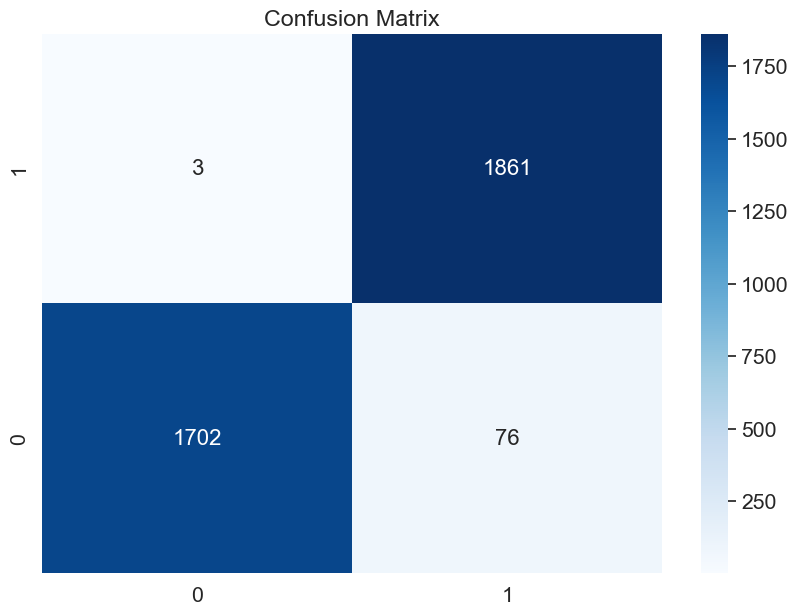

In [103]:
#Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.4) # for label size
sns.set_style("whitegrid")
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
y_pred = grid_clf.predict(X_test)
print("AUC score: ", roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16})
ax.set_ylim([0,2])
plt.show()
